In [23]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee

In [24]:
data = pd.read_table('LCdata.txt', sep='\s+', header = None, names=['time', 'flux'])
timeLC = data['time']
fluxLC = data['flux']
oot = np.abs(24.0*timeLC) >= 1.1 #points outside of transit
errorLC = np.std(fluxLC[oot])

In [25]:
## Planet properties
depth = 0.000174 #initial guess

period =  0.6892099 
ecc = 0.0
b = 0.5 

##Star properties (from Ellen)
mass = 1.00
masserr = 0.04
radius = 1.09
radiuserr = 0.09
u1 = 0.44 #Claret
u2 = 0.24 #Claret
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

In [26]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    """
    # Theta: Vector containing the variables listed above. 
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    #Below are the parameters entered in the previous window. 
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    # Redefinition of the LD coefficients with the parameters used in this function. 
    u1 = 0.5*(sumLD+diffLD) # u1 = 0.5*(u1+u2+(u1-u2)) = 0.5(2u1) = u1
    u2 = sumLD-u1 # u2 = (u1+u2)-u1 = u2
    
    #Use of the transit library. We will generate an artificial light curve with the parameters that we know 
    #and with those that we want to fit. 
    
    # First step: We use the "transit.System(transit.Central()))" module to create a planetary 'system' with a 
    #'central' bright star and a number N (>=0) of bodies in orbit. As the website notes, the default orbits of such
    # celestial objects are 100% Keplerian unless specified with subclasses. The parameters used to model the
    # 'central' star are the LD coefficients (mu1, mu2), its mass (pmass), and its radius (pradius). We have chosen
    # not to include the number of bodies in the system. 

    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    
    # Second step: We will use the "transit.Body" library to define the properties of our planet in the planetary system. 
    # The input parameters are the radius of the planet (r=Rp: this is calculated by taking the sqrt of
    # pdepth -- obtaining Rp/Rs -- and then multiplying by the radius of the star (pradius, which corresponds to Rs)
    # to obtain Rp), its period (given in the previous window), the time at which the transit occurs (t0 = pt0), the 
    # absolute value of the impact parameter, and the eccentricity (which we have also defined in the previous window.) 
    
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    
    # Third step: Add the planet to the system s. 
    s.add_body(body)
    
    # Fourth step: []
        # Question: Why do we need this?
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    # Fifth step: With the definitions of our planet and star, we create a theoretical curve (ftheo). 
    # The input parameters are the times where the light curve should be evaluated in days (timeLC), the time of 
    # exposure (texp = tKep), the "stopping criterion for the exposure time integration" (t01=10^-8), and the 
    # "maximum depth of the exposure time integrator" (maxdepth).
    
        # Questions: How do we infer the values for tol and maxdepth? 
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    
    # Sixth Step: We subtract 1 and add the out of eclipse flux (f0) to our theoretical light curve.  
        #Question: Are we subtracting 1 to normalize the curve? Why is it important to add f0?
    
    ftheo = ftheo-1+f0
    
    # Seventh Step: Returns probability of the theoretical model to be the right model given the parameters that
    # characterize the star and the planet in our system.
    
        # Question: Don't really understand how this probability is calculated. 
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [27]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [28]:
'''It is important that the first argument of the probability function is the position of a single walker 
(a N dimensional numpy array). The following arguments are going to be constant every time the function
is called and the values come from the args parameter of our EnsembleSampler that we’ll see soon.'''

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [29]:
# Lambda is a simple way of writing a scalar function of one or more variables. In our case, we have: 
# x(args)=-lnprob(args).

nll = lambda *args: -lnprob(*args)

# We will now minimize the function nll using the library"scipy.optimize.minimize". 
# The Input parameters are "minimize(1,2,3..)", where 1,2,3... are: 
'''
     1) fun: Our scalar function --> nll
     2) x0: Initial guess --> [1.2*depth, b (impact parameter), 0.0 (t0), 0.0 (sigma), 0.6 (sumLD), mass (mass star), 
            radius (radius star), 1.0 (f0)
     3) args: Extra arguments passed to the objective function & its derivatives --> args = (timeLC, fluxLC,
              errorLC, allfixed)
     4) Options --> options={'disp' : True}. Set to True to print convergence messages
     5) Method: Type of solver (default is None) --> method='Nelder-Mead'. The Nelder-Mead method is used
               to find the minimum or maximum of a function in a many-dimensional space. It's applied to 
               nonlinear optimization problems for which derivatives may not be known."  
 '''

result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')

# Results of minimization (i.e. best guesses for depth, b, t0, sigma, sumLD, mass, radius, f0) are stored in "result"s
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

# Readjust LD coefficients. 
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -2675.866823
         Iterations: 593
         Function evaluations: 917


In [30]:
# Compute the LC integrated over a Kepler long cadence exposure time with the results obtained in minimization process.
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)

t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f-1.0 + f0_ml

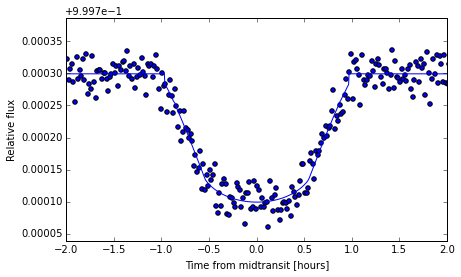

In [31]:
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*timeLC,fluxLC)
plt.xlim([-2.0, 2.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t, f)

In [32]:
#Print the best guesses

depth_ml, b_ml,  t0_ml, sigma_ml

(0.00017649681403018622,
 0.51840307890403792,
 0.00016879320948069183,
 6.266089468994943e-06)

In [ ]:
# From EMCEE Website: 
'''
   Recall: We want the probability density p of having a transit for specific values. The function lnprob returns the
           logarithm of such probabilty (the emcee code requires that we compute the log of p. 
           
   ndim: Nº of dimensions.
   nwalkers: Nº of walkers.
   
   Walkers: Members of the ensemble. The proposal distribution for a given walker depends on the
   positions of all the other walkers in the ensemble. The walkers quickly branch out and explore 
   the rest of the space.   
'''

ndim, nwalkers = 8, 100

# From EMCEE website:
'''
    It's important that the first argument of the probability function is the position of a single walker
    (a N dimensional np.array). The following arguments are going to be constant every time the function is 
    called and the values come from the args parameter of our "EnsembleSampler" that we’ll below. Before we go
    on, we need to guess a starting point for each of the "nwalkers". This position will be a "ndim" vector, so
    the initial guess should be an "nwalkers" by "ndim" array -- or a list of "nwalkers" arrays that each have
    "ndim" elements. It's not a very good guess but we'll just guess a random number between 0 and 1 for each
    
    np.random.randn(): Return a sample (or samples) from the “standard normal” distribution.
'''

pos = [result["x"]*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [ ]:
# From EMCEE website:

'''How to use "emcee.EnsembleSampler(1,2,3...):
        1) nwalkers: Nº of Goodman & Weare “walkers” --> nwalkers
        2) dim: Nº of dimensions in the parameter space --> ndim
        3) lnpostfn: A function that takes a vector in the parameter space as input and returns the 
                     natural logarithm of the posterior probability for that position --> lnprob
        4) a: Optional. Proposal scale parameter. (default: 2.0) --> N/A. 
        5) args=[]: Optional. A list of extra positional arguments for lnpostfn. lnpostfn will be called 
                    with the sequence lnpostfn(p, *args, **kwargs) --> args=(timeLC, fluxLC, errorLC, allfixed)
           
    What happens after each iteration? The ensembleSampler generator gives us: 
        1) pos: A list of the current positions of the walkers in the parameter space. The shape of this object 
                will be (nwalkers, dim).
        2) lnprob: The list of log posterior probabilities for the walkers at positions given by pos. The shape 
                   of this object is (nwalkers, dim).
        3) rstate: The current state of the random number generator.
        4) blobs: Optional. The metadata “blobs” associated with the current position. The value is 
                  only returned if lnpostfn returns blobs too.

'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=(timeLC, fluxLC, errorLC, allfixed))

# We do our production run with 5000 steps.

sampler.run_mcmc(pos, 600)

In [43]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

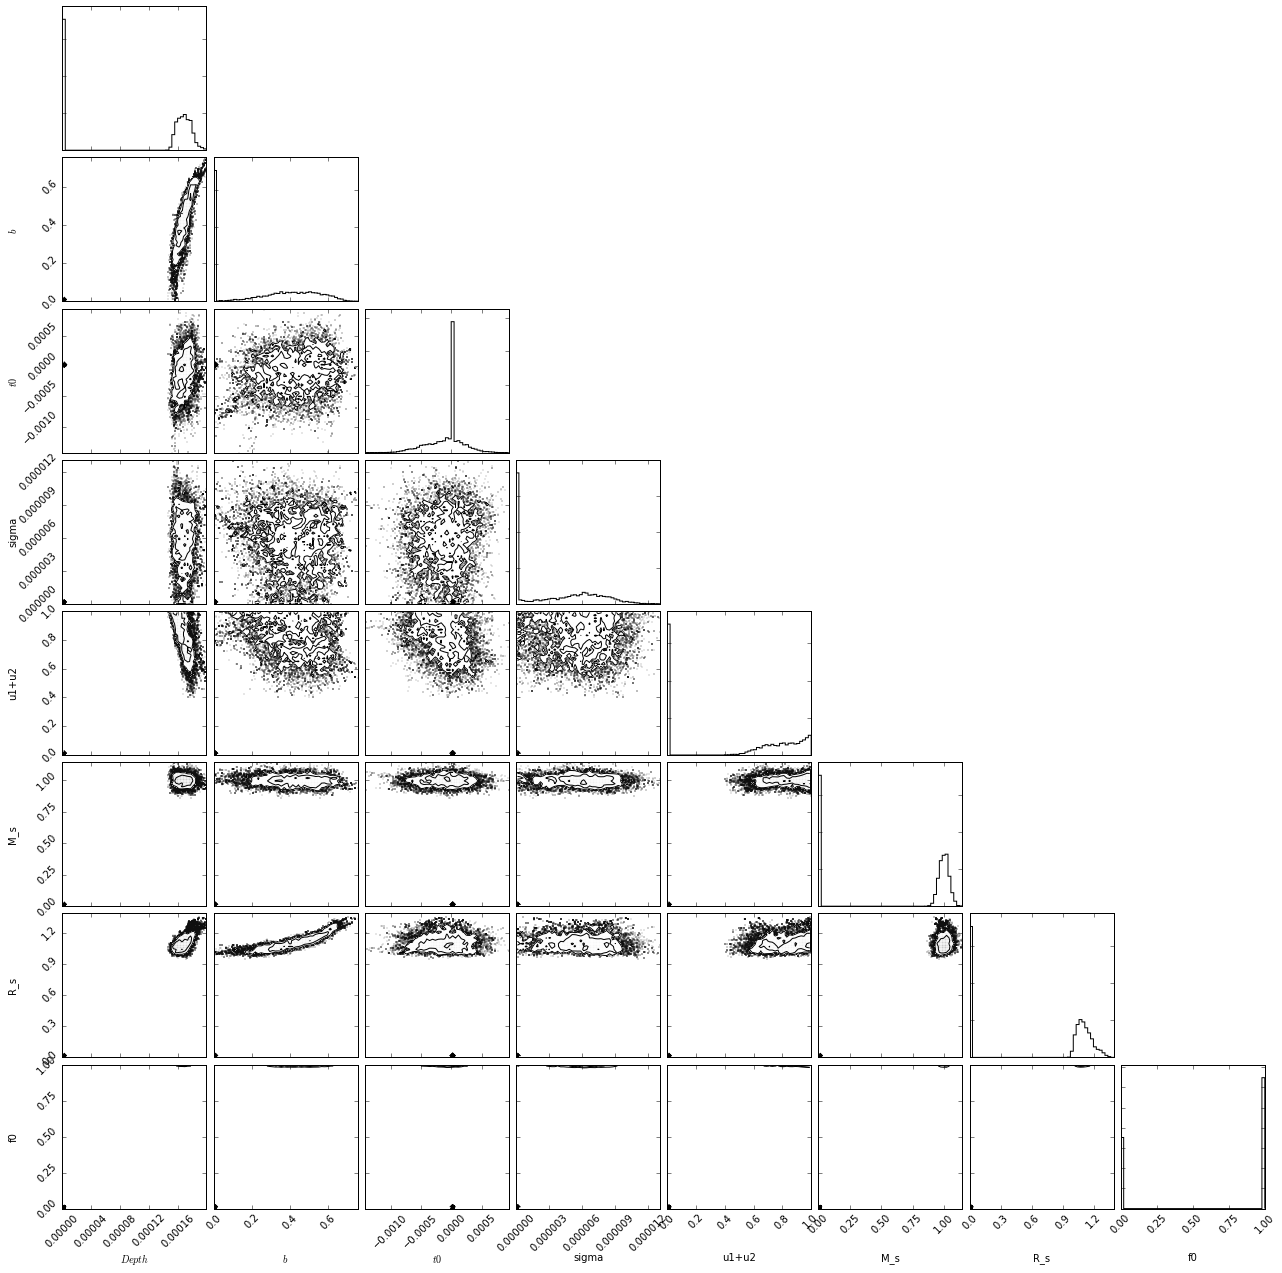

In [44]:
import triangle
fig = triangle.corner(samples, labels=["$Depth$", "$b$", "$t0$", "sigma", "u1+u2", "M_s", "R_s", "f0"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [45]:
samples[:, 2] = np.exp(samples[:, 2])

planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

In [46]:
planetrad_mcmc 

(1.4555033854897235, 0.19954699235013851, 1.4555033854897235)

In [47]:
r_a_mcmc

(0.35333783958258574, nan, 0.032750285885936314)